# PyTorch Image Classifier

## Overview
A complete image classification pipeline supporting multiple pre-trained models with fine-tuning capabilities.

## Key Features
- **Model Support**: ResNet18/50, VGG16, EfficientNet
- **Training**: 
  - Data augmentation (rotation, flipping, color jitter)
  - Learning rate scheduling
  - Model checkpointing
- **Evaluation**:
  - Classification reports (precision/recall/F1)
  - Confusion matrix visualization
  - Training history plots
- **Inference**: Single image prediction capability

## Implementation Details

### Data Preparation
- Automatic class detection from directory structure
- Separate transforms for training (with augmentation) and validation
- DataLoader setup with configurable batch size

### Model Architecture
- Pre-trained models with modified final layers
- Partial fine-tuning (only classifier layers trainable)
- CrossEntropy loss with Adam optimizer

### Training Process
- Epoch-wise training with validation
- Best model saving based on validation accuracy
- Progress tracking with tqdm

### Evaluation Metrics
- Accuracy/Loss tracking
- sklearn classification reports
- Seaborn confusion matrix visualization

## Usage Example
```python
classifier = ImageClassifier(
    data_dir="path/to/data",
    model_name='resnet18',
    batch_size=32,
    learning_rate=0.001
)
classifier.train(num_epochs=10)
classifier.test()

Device: cpu
Number of classes detected: 2
Classes: ['safe', 'unsafe']
Train samples: 1620
Validation samples: 200
Test samples: 200
Model: resnet18
Total parameters: 11177538
Trainable parameters: 1026
Starting training...

Epoch 1/10
------------------------------


Training: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it]


Train Loss: 0.6756, Train Acc: 58.46%
Val Loss: 0.6109, Val Acc: 72.50%
Saved new best model!

Epoch 2/10
------------------------------


Training: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it]


Train Loss: 0.5894, Train Acc: 67.84%
Val Loss: 0.5985, Val Acc: 73.50%
Saved new best model!

Epoch 3/10
------------------------------


Training: 100%|██████████| 51/51 [01:05<00:00,  1.29s/it]


Train Loss: 0.5568, Train Acc: 71.67%
Val Loss: 0.6095, Val Acc: 70.00%

Epoch 4/10
------------------------------


Training: 100%|██████████| 51/51 [01:05<00:00,  1.29s/it]


Train Loss: 0.5459, Train Acc: 72.96%
Val Loss: 0.6018, Val Acc: 72.50%

Epoch 5/10
------------------------------


Training: 100%|██████████| 51/51 [01:07<00:00,  1.31s/it]


Train Loss: 0.5114, Train Acc: 75.93%
Val Loss: 0.5498, Val Acc: 78.00%
Saved new best model!

Epoch 6/10
------------------------------


Training: 100%|██████████| 51/51 [01:05<00:00,  1.29s/it]


Train Loss: 0.5263, Train Acc: 73.89%
Val Loss: 0.6062, Val Acc: 74.00%

Epoch 7/10
------------------------------


Training: 100%|██████████| 51/51 [01:06<00:00,  1.31s/it]


Train Loss: 0.5194, Train Acc: 74.26%
Val Loss: 0.6062, Val Acc: 72.00%

Epoch 8/10
------------------------------


Training: 100%|██████████| 51/51 [01:05<00:00,  1.29s/it]


Train Loss: 0.5182, Train Acc: 75.80%
Val Loss: 0.6706, Val Acc: 67.50%

Epoch 9/10
------------------------------


Training: 100%|██████████| 51/51 [01:06<00:00,  1.30s/it]


Train Loss: 0.5021, Train Acc: 75.99%
Val Loss: 0.5919, Val Acc: 72.50%

Epoch 10/10
------------------------------


Training: 100%|██████████| 51/51 [01:03<00:00,  1.25s/it]


Train Loss: 0.5029, Train Acc: 75.37%
Val Loss: 0.6363, Val Acc: 70.00%


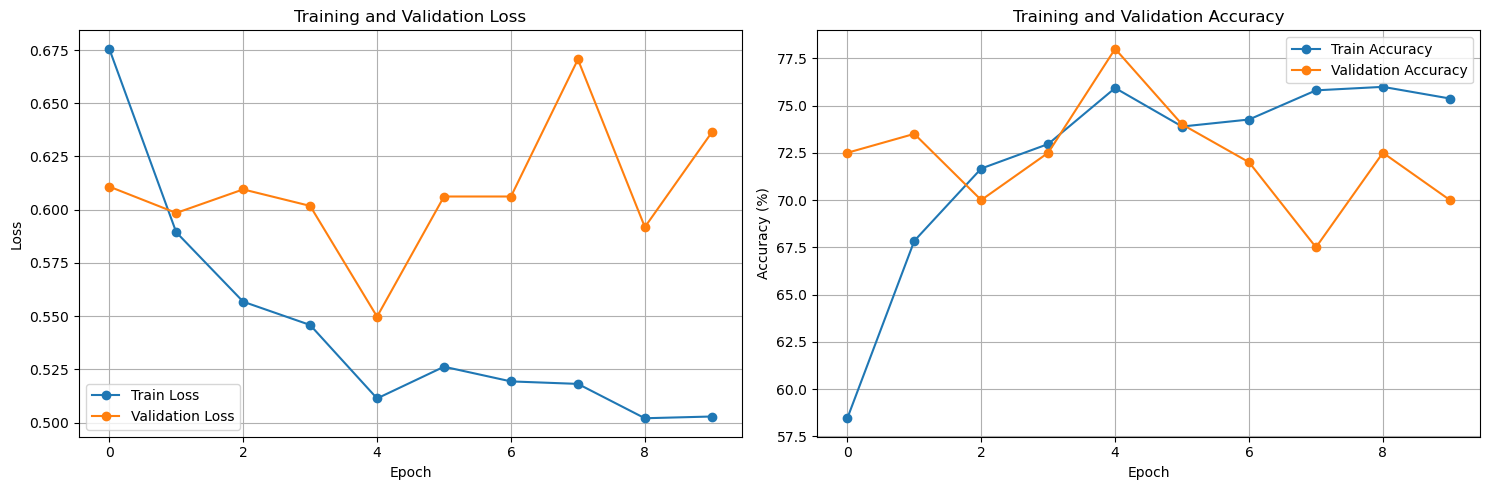

Testing model...

Test Results:
Test Loss: 0.5075
Test Accuracy: 72.50%

Classification Report:
              precision    recall  f1-score   support

        safe     0.7184    0.7400    0.7291       100
      unsafe     0.7320    0.7100    0.7208       100

    accuracy                         0.7250       200
   macro avg     0.7252    0.7250    0.7249       200
weighted avg     0.7252    0.7250    0.7249       200



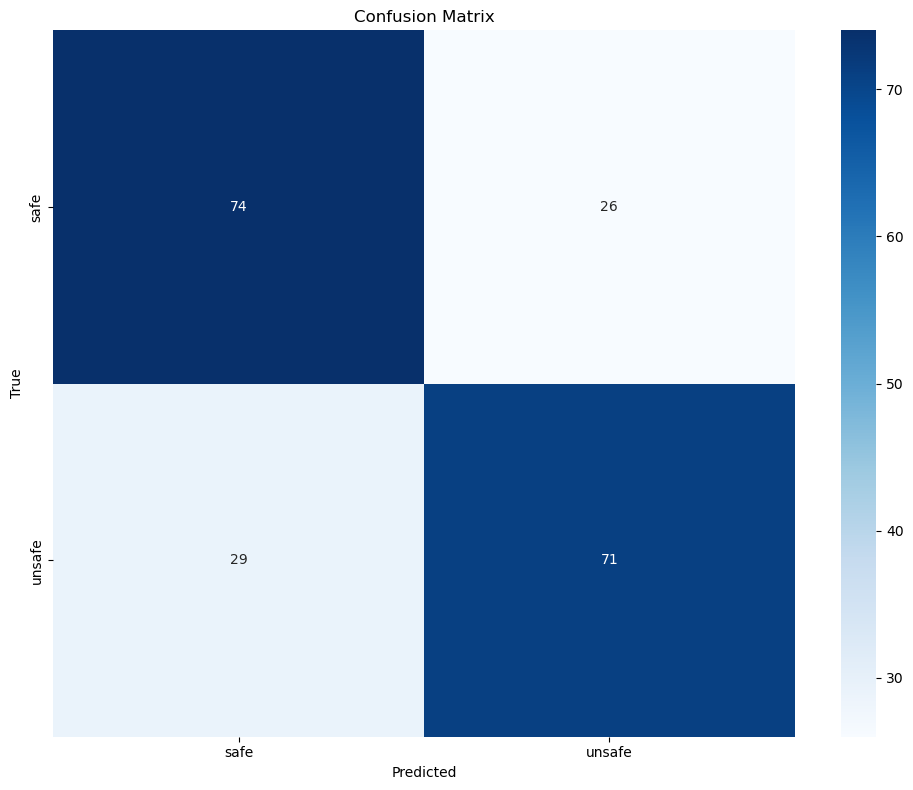

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from tqdm import tqdm

class ImageClassifier:
    def __init__(self, data_dir, model_name='resnet18', num_classes=None, img_size=224, batch_size=32, learning_rate=0.001):
        """
        Initialize the image classifier
        
        Args:
            data_dir (str): Path to dataset directory containing train/test/valid folders
            model_name (str): Pre-trained model to use ('resnet18', 'resnet50', 'efficientnet', 'vgg16')
            num_classes (int): Number of classes (auto-detected if None)
            img_size (int): Input image size
            batch_size (int): Batch size for training
            learning_rate (float): Learning rate for optimizer
        """
        self.data_dir = data_dir
        self.model_name = model_name
        self.img_size = img_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Auto-detect number of classes
        if num_classes is None:
            train_dir = os.path.join(data_dir, 'train')
            self.num_classes = len([d for d in os.listdir(train_dir) 
                                  if os.path.isdir(os.path.join(train_dir, d))])
        else:
            self.num_classes = num_classes
            
        print(f"Device: {self.device}")
        print(f"Number of classes detected: {self.num_classes}")
        
        self.setup_data_transforms()
        self.setup_data_loaders()
        self.setup_model()
        
    def setup_data_transforms(self):
        """Setup data transformations for train and validation"""
        # Training transforms with data augmentation
        self.train_transforms = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        # Validation/Test transforms (no augmentation)
        self.val_transforms = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    def setup_data_loaders(self):
        """Setup data loaders for train, validation, and test sets"""
        # Create datasets
        train_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, 'train'),
            transform=self.train_transforms
        )
        
        val_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, 'valid'),
            transform=self.val_transforms
        )
        
        test_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, 'test'),
            transform=self.val_transforms
        )
        
        # Create data loaders
        self.train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4
        )
        
        self.val_loader = DataLoader(
            val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4
        )
        
        self.test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4
        )
        
        # Store class names
        self.class_names = train_dataset.classes
        print(f"Classes: {self.class_names}")
        print(f"Train samples: {len(train_dataset)}")
        print(f"Validation samples: {len(val_dataset)}")
        print(f"Test samples: {len(test_dataset)}")
    
    def setup_model(self):
        """Setup the pre-trained model"""
        if self.model_name == 'resnet18':
            self.model = models.resnet18(pretrained=True)
            self.model.fc = nn.Linear(self.model.fc.in_features, self.num_classes)
        elif self.model_name == 'resnet50':
            self.model = models.resnet50(pretrained=True)
            self.model.fc = nn.Linear(self.model.fc.in_features, self.num_classes)
        elif self.model_name == 'vgg16':
            self.model = models.vgg16(pretrained=True)
            self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, self.num_classes)
        elif self.model_name == 'efficientnet':
            self.model = models.efficientnet_b0(pretrained=True)
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, self.num_classes)
        else:
            raise ValueError(f"Unsupported model: {self.model_name}")
        
        # Freeze feature extractor layers (fine-tuning)
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze the classifier layer
        if self.model_name in ['resnet18', 'resnet50']:
            for param in self.model.fc.parameters():
                param.requires_grad = True
        elif self.model_name == 'vgg16':
            for param in self.model.classifier.parameters():
                param.requires_grad = True
        elif self.model_name == 'efficientnet':
            for param in self.model.classifier.parameters():
                param.requires_grad = True
        
        self.model = self.model.to(self.device)
        
        # Loss function and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.1)
        
        print(f"Model: {self.model_name}")
        print(f"Total parameters: {sum(p.numel() for p in self.model.parameters())}")
        print(f"Trainable parameters: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}")
    
    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(self.train_loader, desc="Training"):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc
    
    def validate(self, data_loader):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(data_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc, all_predictions, all_labels
    
    def train(self, num_epochs=10):
        """Train the model"""
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        
        best_val_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 30)
            
            # Train
            train_loss, train_acc = self.train_epoch()
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            
            # Validate
            val_loss, val_acc, _, _ = self.validate(self.val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_model.pth')
                print("Saved new best model!")
            
            self.scheduler.step()
        
        # Plot training history
        self.plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies)
        
        return train_losses, train_accuracies, val_losses, val_accuracies
    
    def plot_training_history(self, train_losses, train_accs, val_losses, val_accs):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(train_losses, label='Train Loss', marker='o')
        ax1.plot(val_losses, label='Validation Loss', marker='o')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(train_accs, label='Train Accuracy', marker='o')
        ax2.plot(val_accs, label='Validation Accuracy', marker='o')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def test(self):
        """Test the model and generate classification report"""
        # Load best model
        self.model.load_state_dict(torch.load('best_model.pth'))
        
        test_loss, test_acc, predictions, true_labels = self.validate(self.test_loader)
        
        print(f"\nTest Results:")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.2f}%")
        
        # Classification report
        print("\nClassification Report:")
        report = classification_report(true_labels, predictions, 
                                     target_names=self.class_names, 
                                     digits=4)
        print(report)
        
        # Confusion matrix
        self.plot_confusion_matrix(true_labels, predictions)
        
        return test_acc, report
    
    def plot_confusion_matrix(self, true_labels, predictions):
        """Plot confusion matrix"""
        cm = confusion_matrix(true_labels, predictions)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names,
                    yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def predict_single_image(self, image_path):
        """Predict a single image"""
        from PIL import Image
        
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.val_transforms(image).unsqueeze(0).to(self.device)
        
        # Predict
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
            predicted_class = torch.argmax(probabilities).item()
            confidence = probabilities[predicted_class].item()
        
        return self.class_names[predicted_class], confidence, probabilities.cpu().numpy()

# Example usage
if __name__ == "__main__":
    # Initialize classifier
    data_dir = "Worksite-Safety-Monitoring-Dataset"  # Change this to your dataset path
    
    classifier = ImageClassifier(
        data_dir=data_dir,
        model_name='resnet18',  # Options: 'resnet18', 'resnet50', 'vgg16', 'efficientnet'
        batch_size=32,
        learning_rate=0.001
    )
    
    # Train the model
    print("Starting training...")
    train_losses, train_accs, val_losses, val_accs = classifier.train(num_epochs=10)
    
    # Test the model
    print("Testing model...")
    test_accuracy, classification_report = classifier.test()
    
    # Predict a single image (optional)
    # predicted_class, confidence, probabilities = classifier.predict_single_image("path/to/test/image.jpg")
    # print(f"Predicted: {predicted_class} (Confidence: {confidence:.4f})")

Predicted: safe (Confidence: 0.7501)
Class probabilities: [0.75009483 0.24990523]


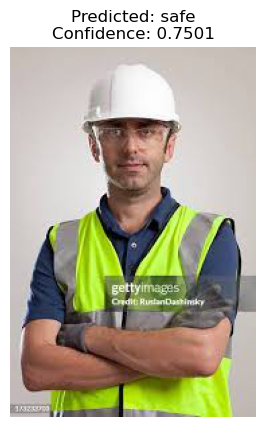

In [45]:
import matplotlib.pyplot as plt
from PIL import Image

# Predict the class of a single image
image_path = "download (39).jpeg"
predicted_class, confidence, probabilities = classifier.predict_single_image(image_path)

# Print the results
print(f"Predicted: {predicted_class} (Confidence: {confidence:.4f})")
print("Class probabilities:", probabilities)

# Show the image with prediction as title
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.4f}")
plt.show()


Predicted: unsafe (Confidence: 0.6517)
Class probabilities: [0.34828472 0.6517153 ]


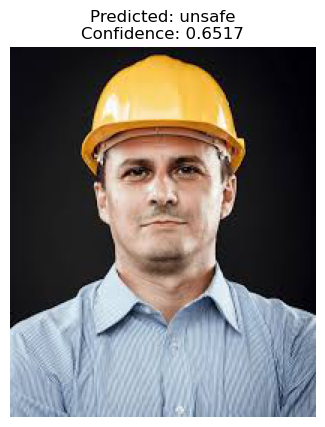

In [49]:
import matplotlib.pyplot as plt
from PIL import Image

# Predict the class of a single image
image_path = "download (38).jpeg"
predicted_class, confidence, probabilities = classifier.predict_single_image(image_path)

# Print the results
print(f"Predicted: {predicted_class} (Confidence: {confidence:.4f})")
print("Class probabilities:", probabilities)

# Show the image with prediction as title
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.4f}")
plt.show()


In [48]:
# Add this to your SafetyClassifier __init__ method:
print(f"Class mappings: {self.class_names}")
# Should output: ['Unsafe', 'Safe']

NameError: name 'self' is not defined